## Segmentation using UNet
### Notes:
- I used 2 dataset folders
  - `dataset`: 500 img, 3 classes
  - `new_dataset`: 4 img, 2 classes
- Dataloader
  - Loads data in `data` and `label` variables
  - `data` is a grayscale image of size `[496,496]`
  - `label` is a `[n, 496,496]` array where `n` is the number of classes
- Model
  - Outputs a `[n, 496,496]` array where the first dimension is the certainty per class
- New dataset
  - Allows for using old weights, and training last layer while freezing all others

### Contents:
- Dataloader
- Check for Cuda
- Set up model (pytorch)
- Loss function
- Get data loaders (train, val, test)
- Main trianing loop
- Run training loop
- Save and load model `.pt` file
- Load 3-class model into 2-class model, and train last layer (from `dataset` to `new_dataset`)
- Evaluate
- Plot results

### Imports

In [2]:
import os
import cv2

import numpy as np 
import pandas as pd 

from sklearn.model_selection import train_test_split

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
from collections import defaultdict
import torch.nn.functional as F
import torch
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision.transforms.functional

import torch.nn as nn
from torch.nn.functional import relu

from PIL import Image

import time
import copy

import random

### Dataloader
Has a `convert_to_grayscale` function that converts grayscale image to `[n, 496,496]` array, where the first dimension has value 0.0 or 1.0 depending on what class it is

In [3]:
class TIFFLoader(Dataset):
    def __init__(self, directory, indices, transform=None, nr_classes=3, img_size=(496,496)):
        self.data_directory = os.path.join(directory, 'data')
        self.label_directory = os.path.join(directory, 'labels')
        self.transform = transform
        self.indices = indices
        self.nr_classes = nr_classes
        self.img_size = img_size

        # get all file names
        self.data_paths = [file for file in os.listdir(self.data_directory) if file.endswith(('tiff', 'tif', 'png'))]
        self.label_paths = [file for file in os.listdir(self.label_directory) if file.endswith(('tiff', 'tif', 'png'))]

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        data_path = os.path.join(self.data_directory, self.data_paths[self.indices[idx]])
        label_path = os.path.join(self.label_directory, self.label_paths[self.indices[idx]])

        # as image gets downscaled, it should be divisible by 2^4, such as 496 or 512
        # TODO: test what way of scaling gives best results
        # for 3 channels cv2.imread(..)
        # for 1 channel cv2.imread(.., cv2.IMREAD_GRAYSCALE)
        #print(data_path)
        data = self.transform(cv2.resize(cv2.imread(data_path, cv2.IMREAD_GRAYSCALE), self.img_size)) # (496, 496) (128, 128)
        #print(data)
        label = self.transform(self.convert_to_classes(cv2.resize(cv2.imread(label_path, cv2.IMREAD_GRAYSCALE), self.img_size, interpolation=cv2.INTER_NEAREST))) # (496, 496) (128, 128)
        return [data, label]
    
    def convert_to_classes(self, grayscale):
        """Converts grayscale image to 3D array with classes

        Args:
            grayscale (np array): [width, height]

        Returns:
            3D array with classes: [width, height, nr_classes]
        """
        label_values = np.unique(grayscale)
        #print(self.nr_classes)
        #print(label_values)
        assert self.nr_classes == len(label_values), "more colors in labels than classes chosen"
        
        classes = np.zeros((self.img_size[0], self.img_size[1], self.nr_classes)) # grayscale.shape
        for x in range(len(grayscale)):
            for y in range(len(grayscale[0])):
                for idx, label in enumerate(label_values):
                    if grayscale[x,y] == label:
                        classes[x,y, idx] = 1.0
                        continue
        return classes

In [4]:
#demo = TIFFLoader('D:/GoodSync/edu_DTU/02456_deep_learning/xray-segmentation/new_dataset/', [0,1,2,3], transform=transforms.ToTensor(), nr_classes=2)

### Check for Cuda

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### Set up model
Based of this repository (standard UNet model): https://github.com/Mostafa-wael/U-Net-in-PyTorch

In [7]:
class DoubleConvolution(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()

        # First 3x3 convolutional layer
        self.first = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.act1 = nn.ReLU()
        # Second 3x3 convolutional layer
        self.second = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.act2 = nn.ReLU()

    def forward(self, x: torch.Tensor):
        # Apply the two convolution layers and activations
        x = self.first(x)
        x = self.act1(x)
        x = self.second(x)
        return self.act2(x)

class DownSample(nn.Module):
    def __init__(self):
        super().__init__()
        # Max pooling layer
        self.pool = nn.MaxPool2d(2)

    def forward(self, x: torch.Tensor):
        return self.pool(x)

class UpSample(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()

        # Up-convolution
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

    def forward(self, x: torch.Tensor):
        return self.up(x)

class CropAndConcat(nn.Module):
    def forward(self, x: torch.Tensor, contracting_x: torch.Tensor):
        # Crop the feature map from the contracting path to the size of the current feature map
        contracting_x = torchvision.transforms.functional.center_crop(contracting_x, [x.shape[2], x.shape[3]])
        # Concatenate the feature maps
        x = torch.cat([x, contracting_x], dim=1)
        return x

class UNet(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):

        super().__init__()
        # Double convolution layers for the contracting path.
        # The number of features gets doubled at each step starting from 64.
        # NOTE: changed from (3,64) to (1,64)
        down_conv_sizes = [(in_channels, 64), (64, 128), (128, 256), (256, 512)]
        self.down_conv = nn.ModuleList([DoubleConvolution(i, o) for i, o in down_conv_sizes])
        
        # Down sampling layers for the contracting path
        self.down_sample = nn.ModuleList([DownSample() for _ in range(4)])

        # The two convolution layers at the lowest resolution (the bottom of the U).
        self.middle_conv = DoubleConvolution(512, 1024)

        # Up sampling layers for the expansive path.
        # The number of features is halved with up-sampling.
        upsample_sizes = [(1024, 512), (512, 256), (256, 128), (128, 64)]
        
        self.up_sample = nn.ModuleList([UpSample(i, o) for i, o in upsample_sizes])
        # Double convolution layers for the expansive path.
        # Their input is the concatenation of the current feature map and the feature map from the
        # contracting path. Therefore, the number of input features is double the number of features
        # from up-sampling.
        up_conv_sizes = [(1024, 512), (512, 256), (256, 128), (128, 64)]
        self.up_conv = nn.ModuleList([DoubleConvolution(i, o) for i, o in up_conv_sizes])
        
        # Crop and concatenate layers for the expansive path.
        self.concat = nn.ModuleList([CropAndConcat() for _ in range(4)])
        
        # Final 1x1 convolution layer to produce the output
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x: torch.Tensor):
        # To collect the outputs of contracting path for later concatenation with the expansive path.
        pass_through = []
        # Contracting path
        for i in range(len(self.down_conv)):
            # Two 3x3 convolutional layers
            x = self.down_conv[i](x)
            # Collect the output
            pass_through.append(x)
            # Down-sample
            x = self.down_sample[i](x)

        # Two 3x3 convolutional layers at the bottom of the U-Net
        x = self.middle_conv(x)

        # Expansive path
        for i in range(len(self.up_conv)):
            # Up-sample
            x = self.up_sample[i](x)
            # Concatenate the output of the contracting path
            x = self.concat[i](x, pass_through.pop())
            # Two 3x3 convolutional layers
            x = self.up_conv[i](x)

        # Final 1x1 convolution layer
        out = self.final_conv(x)

        return out

### Loss function
`calc_loss` was function used by repo.

`custom_loss` is our simpler version of loss function, that we use now.

In [8]:
# NOT USED
def dice_loss(pred, target, smooth=1.):
    pred = pred.contiguous()
    target = target.contiguous()

    intersection = (pred * target).sum(dim=2).sum(dim=2)

    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))

    return loss.mean()

# NOT USED
def calc_loss(pred, target, metrics, bce_weight=0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)

    pred = F.sigmoid(pred)
    dice = dice_loss(pred, target)

    loss = bce * bce_weight + dice * (1 - bce_weight)

    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)

    return loss

def custom_loss(pred, target, metrics):
    """
    pred: as [2,3,496,496] representing 3 classes
    target: as [2,1,496,496] representing grayscale goal
    """
    
    #classes = torch.clone(target) # copy target clone
    #classes = classes.expand(1, 3) # expand to [2,3,496,496]
    # modify to represent class probabilities based on pixel color
    loss = F.cross_entropy(pred, target)
    metrics['loss'] = loss
    return loss

### Get data loaders
Load appropriate number of files (semi-randomly with seed), and splits these up in `train`, `val`, `test`.

In [9]:
def get_data_loaders(batch_size=2, num_files=200, nr_classes=3, path="./dataset/"):
    # use the same transformations for train/val in this example

    def split_indices(n, train_ratio=0.7, val_ratio=0.2, seed=42):
        # Set the seed for reproducibility
        random.seed(seed)

        indices = list(range(n))
        random.shuffle(indices)
        train_size = round(n * train_ratio)
        val_size = round(n * val_ratio)
        # ensure that all sets are at least 1
        if val_size == 0:
            train_size -= 1
            val_size = 1
        test_size = n - train_size-val_size
        if test_size == 0:
            train_size -= 1
            test_size = 1
        return indices[:train_size], indices[train_size:train_size+test_size], indices[train_size+test_size:]

    # Assuming the number of data and label files are the same
    #num_files = len(os.listdir('./dataset/data'))

    # Split indices
    train_indices, val_indices, test_indices = split_indices(num_files)

    # Create datasets
    #train_set = TIFFLoader('./new_dataset/', train_indices, transform=transforms.ToTensor(), nr_classes=2)
    train_set = TIFFLoader(path, train_indices, transform=transforms.ToTensor(), nr_classes=nr_classes)
    val_set = TIFFLoader(path, val_indices, transform=transforms.ToTensor(), nr_classes=nr_classes)
    test_set = TIFFLoader(path, test_indices, transform=transforms.ToTensor(), nr_classes=nr_classes)

    dataloaders = {
        'train': DataLoader(train_set, batch_size=batch_size, shuffle=False, num_workers=0),
        'val': DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=0),
        'test': DataLoader(test_set, batch_size=1, shuffle=False, num_workers=0)
    }

    return dataloaders

In [10]:
def print_metrics(metrics, epoch_samples, phase):
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))

    print("{}: {}".format(phase, ", ".join(outputs)))

### Main training loop

In [11]:
def train_model(model, optimizer, scheduler, num_epochs=25, num_files=200, nr_classes=3, path="./dataset/"):
    dataloaders = get_data_loaders(num_files=num_files, nr_classes=nr_classes, path=path)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])

                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    #loss = calc_loss(outputs, labels, metrics)
                    #fn = nn.CrossEntropyLoss()
                    #loss = fn(outputs, labels)
                    loss = custom_loss(outputs, labels, metrics)
                    #loss = F.binary_cross_entropy(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                epoch_samples += inputs.size(0)

            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print("saving best model")
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

***

### Run training (takes a while)
- To change runnion time (and quality)
  - Set `num_epochs` (30 for example)
  - Set `num_files` (200 for example)
- Set right path (`./dataset/` or `./new_dataset/`)
- I haven't changed `lr=1e-4`, `step_size=30`, or `gamma=0.1` much
- change `num_class` depending on dataset (3 or 2)

In [11]:
num_class = 3
model = UNet(1, num_class).to(device)

optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=30, gamma=0.1)

model = train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=10, num_files=50, nr_classes=num_class, path="./dataset/")

Epoch 0/9
----------
LR 0.0001


C:\Users\David\AppData\Roaming\Python\Python39\site-packages\torch\optim\lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


train: loss: 0.030982
val: loss: 0.216039
saving best model
0m 32s
Epoch 1/9
----------
LR 0.0001
train: loss: 0.029104
val: loss: 0.197500
saving best model
0m 30s
Epoch 2/9
----------
LR 0.0001
train: loss: 0.015719
val: loss: 0.128625
saving best model
0m 27s
Epoch 3/9
----------
LR 0.0001
train: loss: 0.009795
val: loss: 0.060861
saving best model
0m 26s
Epoch 4/9
----------
LR 0.0001
train: loss: 0.007984
val: loss: 0.047028
saving best model
0m 27s
Epoch 5/9
----------
LR 0.0001
train: loss: 0.006439
val: loss: 0.038519
saving best model
0m 27s
Epoch 6/9
----------
LR 0.0001
train: loss: 0.005338
val: loss: 0.033361
saving best model
0m 28s
Epoch 7/9
----------
LR 0.0001
train: loss: 0.004612
val: loss: 0.031067
saving best model
0m 28s
Epoch 8/9
----------
LR 0.0001
train: loss: 0.004152
val: loss: 0.028274
saving best model
0m 28s
Epoch 9/9
----------
LR 0.0001
train: loss: 0.003836
val: loss: 0.024781
saving best model
0m 28s
Best val loss: 0.024781


### Save model

In [12]:
# save the model to file
#state = {'epoch': epoch + 1, 'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict(), 'losslogger': losslogger, }
state = {'state_dict': model.state_dict(), 'optimizer': optimizer_ft.state_dict() }
torch.save(state, "unet_v12_10epoch_50img.pt")

### Load model from file (when not retraining)

In [ ]:
# load the model from file
model = UNet(1, 3).to(device)
state = torch.load("unet_model_v11_30epoch_200img.pt", map_location=device)
model.load_state_dict(state['state_dict'])
#model.eval()

***

### Load 3-class model as 2-class model, and retrain final layer
1. Set up 2-class model
2. Set final layer to 3-class (so that we can load old weights)
3. Load old weights (some `.pt` files only contain state_dict, others also optimzer, see code)
4. Optional: load old optimizer
5. Set final layer to 2-class
6. Freeze all layers except last
7. Continue training

In [41]:
# set up model
num_class = 2
model = UNet(1, num_class).to(device)
optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=30, gamma=0.1)

# temp set to 3 classes to load old model (alternative is manipulating state_dict?)
model.final_conv = nn.Conv2d(64, 3, kernel_size=1) 

# load state_dict (weights) and optimizer (needed for training)
state = torch.load("unet_model_v11_30epoch_200img.pt", map_location=device)
model.load_state_dict(state)

#state = torch.load("unet_v12_10epoch_50img.pt", map_location=device)
#model.load_state_dict(state['state_dict'])
#optimizer_ft.load_state_dict(state['optimizer'])

# set back to 2 classes
model.final_conv = nn.Conv2d(64, num_class, kernel_size=1) 

# freeze all layers except last
if True:
    i = 0
    for param in model.parameters():
        #print(i, param.size(), i > 41)
        param.requires_grad = i > 41
        i+=1

# to gpu
model = model.to(device)

In [42]:
num_class = 2
model = train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=50, num_files=4, nr_classes=num_class, path="./new_dataset/")

Epoch 0/49
----------
LR 0.0001


C:\Users\David\AppData\Roaming\Python\Python39\site-packages\torch\optim\lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


train: loss: 1.388522
val: loss: 2.121916
saving best model
0m 2s
Epoch 1/49
----------
LR 0.0001
train: loss: 1.221638
val: loss: 1.833924
saving best model
0m 2s
Epoch 2/49
----------
LR 0.0001
train: loss: 1.055300
val: loss: 1.546656
saving best model
0m 2s
Epoch 3/49
----------
LR 0.0001
train: loss: 0.889401
val: loss: 1.260366
saving best model
0m 2s
Epoch 4/49
----------
LR 0.0001
train: loss: 0.724062
val: loss: 0.976384
saving best model
0m 2s
Epoch 5/49
----------
LR 0.0001
train: loss: 0.560001
val: loss: 0.700353
saving best model
0m 2s
Epoch 6/49
----------
LR 0.0001
train: loss: 0.400265
val: loss: 0.461588
saving best model
0m 2s
Epoch 7/49
----------
LR 0.0001
train: loss: 0.260401
val: loss: 0.434709
saving best model
0m 3s
Epoch 8/49
----------
LR 0.0001
train: loss: 0.228270
val: loss: 0.882557
0m 2s
Epoch 9/49
----------
LR 0.0001
train: loss: 0.432728
val: loss: 0.924057
0m 2s
Epoch 10/49
----------
LR 0.0001
train: loss: 0.451638
val: loss: 0.664269
0m 2s
Epoch 1

In [43]:
state = {'state_dict': model.state_dict(), 'optimizer': optimizer_ft.state_dict() }
torch.save(state, "unet_2class_v1_based_on_v11.pt")

***

### Evaluate
> **_NOTE:_**  Select the right dataloaders (`dataset` or `new_dataset`)

In [44]:
# Set model to the evaluation mode
model.eval()

#loaders = get_data_loaders(num_files=200, nr_classes=3, path="./dataset/")
loaders = get_data_loaders(num_files=4, nr_classes=2, path="./new_dataset/")

# Get the first batch
inputs, labels = next(iter(loaders['test']))
inputs = inputs.to(device)
labels = labels.to(device)

# Predict
with torch.no_grad():
    pred = model(inputs)
# The loss functions include the sigmoid function.
pred = F.sigmoid(pred)
pred = pred.data.cpu().numpy()

### Separate prediction data into discrete images (either for 2 or 3 outputs)

In [49]:
def prob_to_gray(probabilities):
    """
    Convert probabilities for 2 or 3 classes to a grayscale image

    Args:
        probabilities (numpy array): [2 or 3,496,496]

    Returns:
        numpy array: [496,496] grayscale images, ranging [0.0, 1.0]
    """
    if np.shape(probabilities)[0] == 3:
        return np.argmax(probabilities, 0.5)
    elif np.shape(probabilities)[0] == 2:
        return np.argmax(probabilities, 0)
    else:
        print("???")

In [56]:
print("total:", 496**2)
print("0s:", np.count_nonzero(np.argmax(pred[0], 0) == 0))
print("1s:", np.count_nonzero(np.argmax(pred[0], 0) == 1))
print("2s:", np.count_nonzero(np.argmax(pred[0], 0) == 2))

total: 246016
0s: 222698
1s: 23318
2s: 0


### Plot one image prediction

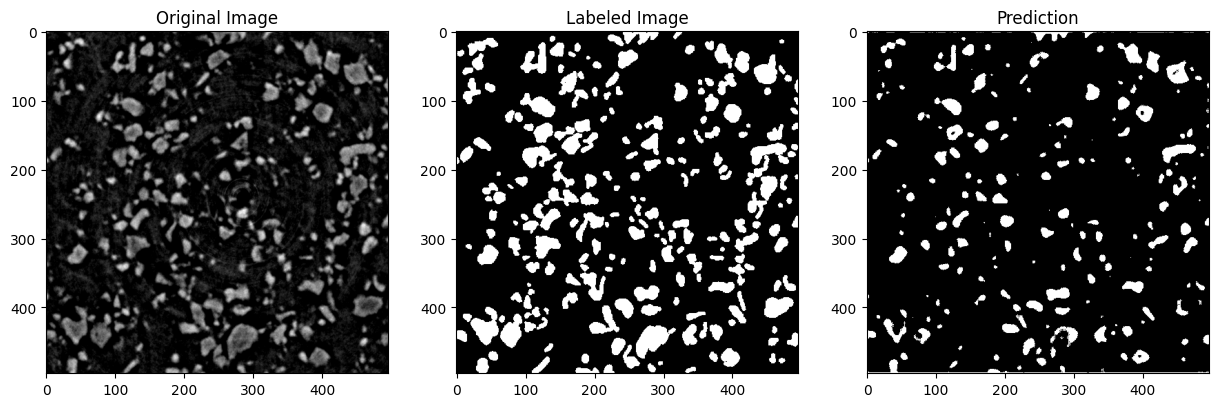

In [55]:

import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))  # Increase the figure size for better visibility

# Plot the original image
plt.subplot(1, 3, 1)  # 1 row, 3 columns, first subplot
img_original = inputs[0].cpu()[0,:,:]
plt.imshow(img_original, cmap='gray')
plt.title('Original Image')

# Plot the labeled image
plt.subplot(1, 3, 2)  # 1 row, 3 columns, second subplot
img_labeled = prob_to_gray(labels[0].cpu())
plt.imshow(img_labeled, cmap='gray')  # You might not need cmap='gray' if it's a color label image
plt.title('Labeled Image')

# Plot the prediction image
plt.subplot(1, 3, 3)  # 1 row, 3 columns, third subplot
#img_predicted = prob_to_gray(pred[:,0])
img_predicted = prob_to_gray(pred[0])
plt.imshow(img_predicted, cmap='gray')
plt.title('Prediction')

# Show the plot
plt.show()